[View in Colaboratory](https://colab.research.google.com/github/jagatfx/turicreate-colab/blob/master/turicreate_image_classification.ipynb)

# Image Classification
https://apple.github.io/turicreate/docs/userguide/image_classifier/

Given an image, the goal of an image classifier is to assign it to one of a pre-determined number of labels. Deep learning methods have recently been shown to give incredible results on this challenging problem. Yet this comes at the cost of extreme sensitivity to model hyper-parameters and long training time. This means that one can spend months testing different model configurations, much too long to be worth the effort. However, the image classifier in Turi Create is designed to minimize these pains, and making it possible to easily create a high quality image classifier model.

The Turi Create image classifier breaks things down into something like this:

*   Stage 1: Create a CNN classifier on a large, general dataset. A good example is ImageNet, with 1000 categories and 1.2 million images. The models are already trained by researchers and are available for us to use.

*   Stage 2: The outputs of each layer in the CNN can be viewed as a meaningful vector representation of each image. Extract these feature vectors from the layer prior to the output layer on each image of your task.

*   Stage 3: Create a new classifier with those features as input for your own task.

Stage 1 is reusable for many different problems, and once done, it doesn't have to be changed often.

In the end, this pipeline results in not needing to adjust hyper-parameters, faster training, and better performance even in cases where you don't have enough data to create a convention deep learning model. What's more, this technique is effective even if your Stage 3 classification task is relatively unrelated to the task Stage 1 is trained on. This idea was first explored by Donahue et al. (2013), and has since become one of the best ways to create image classifier models.

## Turi Create and GPU Setup

In [9]:
!apt install libnvrtc8.0
!pip uninstall -y mxnet-cu80 && pip install mxnet-cu80==1.1.0
!pip install turicreate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libnvrtc8.0
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 6,225 kB of archives.
After this operation, 28.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Fetched 6,225 kB in 0s (39.2 MB/s)
Selecting previously unselected package libnvrtc8.0:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libnvrtc8.0_8.0.61-1_amd64.deb ...
Unpacking libnvrtc8.0:amd64 (8.0.61-1) ...
Setting up libnvrtc8.0:amd64 (8.0.61-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Skipping mxnet-cu80 as it is not installed.
    100% |████████████████████████████████| 274.9MB 103kB/s 
    100% |████████████████████████████████| 17.0MB 2.5MB/s 
  Found existing installation: numpy 1.14.5
 

## Google Drive Access

You will be asked to click a link to generate a secret key to access your Google Drive. 

Copy and paste secret key it into the space provided with the notebook.

In [2]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

Google Drive already mounted


## Fetch Data

In [0]:
import os.path
import urllib.request
import tarfile
import zipfile
import gzip
from shutil import copy

def fetch_remote_datafile(filename, remote_url):
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
    return
  print("fetching " + filename + " from " + remote_url + "...")
  urllib.request.urlretrieve(remote_url, "./" + filename)

def cache_datafile_in_drive(filename):
  if os.path.isfile("./" + filename) == False:
    print("cannot cache " + filename + ", it is not in workspace")
    return
  
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile(data_drive_path + filename):
    print("" + filename + " has already been stored in Google Drive")
  else:
    print("copying " + filename + " to " + data_drive_path)
    copy("./" + filename, data_drive_path)
  

def load_datafile_from_drive(filename, remote_url=None):
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
  elif os.path.isfile(data_drive_path + filename):
    print("have " + filename + " in Google Drive, copying to workspace...")
    copy(data_drive_path + filename, ".")
  elif remote_url != None:
    fetch_remote_datafile(filename, remote_url)
  else:
    print("error: you need to manually download " + filename + " and put in drive")
    
def extract_datafile(filename, expected_extract_artifact=None):
  if expected_extract_artifact != None and (os.path.isfile(expected_extract_artifact) or os.path.isdir(expected_extract_artifact)):
    print("files in " + filename + " have already been extracted")
  elif os.path.isfile("./" + filename) == False:
    print("error: cannot extract " + filename + ", it is not in the workspace")
  else:
    extension = filename.split('.')[-1]
    if extension == "zip":
      print("extracting " + filename + "...")
      data_file = open(filename, "rb")
      z = zipfile.ZipFile(data_file)
      for name in z.namelist():
          print("    extracting file", name)
          z.extract(name, "./")
      data_file.close()
    elif extension == "gz":
      print("extracting " + filename + "...")
      if filename.split('.')[-2] == "tar":
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
      else:
        data_zip_file = gzip.GzipFile(filename, 'rb')
        data = data_zip_file.read()
        data_zip_file.close()
        extracted_file = open('.'.join(filename.split('.')[0:-1]), 'wb')
        extracted_file.write(data)
        extracted_file.close()
    elif extension == "tar":
      print("extracting " + filename + "...")
      tar = tarfile.open(filename)
      tar.extractall()
      tar.close()
    elif extension == "csv":
      print("do not need to extract csv")
    else:
      print("cannot extract " + filename)
      
def load_cache_extract_datafile(filename, expected_extract_artifact=None, remote_url=None):
  load_datafile_from_drive(filename, remote_url)
  extract_datafile(filename, expected_extract_artifact)
  cache_datafile_in_drive(filename)
  

In [12]:
# kagglecatsanddogs_3367a.zip from https://www.microsoft.com/en-us/download/details.aspx?id=54765
load_cache_extract_datafile("kagglecatsanddogs_3367a.zip", "PetImages")

already have kagglecatsanddogs_3367a.zip in workspace
files in kagglecatsanddogs_3367a.zip have already been extracted
kagglecatsanddogs_3367a.zip has already been stored in Google Drive


## Setup Turi Create

In [0]:
import mxnet as mx
import turicreate as tc

In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

## Loading Data

The Kaggle Cats and Dogs Dataset provides labeled cat and dog images. 

https://www.microsoft.com/en-us/download/details.aspx?id=54765

(use kagglecatsanddogs/PetImages directory)

(alternatively you can use: https://www.kaggle.com/c/dogs-vs-cats/data#)

In [11]:
# Load images (Note: you can ignore 'Not a JPEG file' errors)
reference_data = tc.image_analysis.load_images('./PetImages', with_path=True)

# From the path-name, create a label column
reference_data['label'] = reference_data['path'].apply(lambda path: 'dog' if '/Dog' in path else 'cat')

# Save the data for future use
reference_data.save('cats-dogs.sframe')

Unexpected JPEG decode failure	 file: ./PetImages/Cat/10073.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/10125.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/10404.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/10501.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/10820.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/10874.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11083.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11086.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11095.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11210.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11397.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/1151.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11565.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11729.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11864.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11874.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/11935.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/12080.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/12235.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/12269.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/1267.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/1386.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/140.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/1757.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/1914.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/1936.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/1937.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/2021.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/2189.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/23.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/2569.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/2663.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/2742.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3153.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3161.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3197.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3300.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3491.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3649.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3710.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/391.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/3967.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4000.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4293.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4322.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4334.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4351.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/445.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4629.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4750.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4821.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4833.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4874.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/4929.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/5077.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/5370.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/5553.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/5614.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/5819.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6029.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6376.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6435.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6486.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6491.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/660.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/666.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6768.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6900.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6906.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/6980.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/7003.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/7502.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/7642.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/7647.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/7845.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/7968.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/7978.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/8183.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/8295.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/8415.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/8470.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/850.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/8553.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/8832.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/8958.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/910.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9100.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9171.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9208.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9328.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/936.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9361.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9565.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9619.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Cat/9778.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10158.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1017.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10173.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10351.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10353.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10383.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10401.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10637.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10678.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10705.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10726.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10733.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10747.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10797.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10863.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10907.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10969.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/10972.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11166.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11233.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11253.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11285.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11410.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11560.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11590.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11675.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1168.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11692.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11702.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11849.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11853.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/11912.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/12102.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/12114.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/12289.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1259.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1308.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1356.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1866.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1884.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/1900.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2317.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2353.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2384.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2479.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2494.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2688.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2877.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2905.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/2915.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/296.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3038.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3136.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3155.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3288.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3320.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3546.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3588.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3885.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/3927.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4086.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4134.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/414.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4203.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4257.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4301.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4367.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4640.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4654.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/4924.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/50.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5104.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/522.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5243.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5263.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/543.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5547.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5604.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/561.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5618.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/565.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/573.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5730.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5736.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5790.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/5955.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6032.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6059.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6213.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6238.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6305.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6318.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6430.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6500.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6503.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6555.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/663.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6718.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/6855.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7112.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7128.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7133.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/719.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7311.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7369.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7459.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7514.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7652.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7718.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7739.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7743.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/7969.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8126.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8194.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8364.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8521.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8557.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8563.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8641.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8693.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8715.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8730.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/8889.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9026.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9043.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9145.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9188.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9367.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9414.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9500.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9556.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9640.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9643.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9851.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9961.jpg

Unexpected JPEG decode failure	 file: ./PetImages/Dog/9967.jpg

In [12]:
reference_data.head()

path,image,label
./PetImages/Cat/0.jpg,Height: 375 Width: 500,cat
./PetImages/Cat/1.jpg,Height: 281 Width: 300,cat
./PetImages/Cat/10.jpg,Height: 500 Width: 489,cat
./PetImages/Cat/100.jpg,Height: 500 Width: 403,cat
./PetImages/Cat/1000.jpg,Height: 150 Width: 150,cat
./PetImages/Cat/10000.jpg,Height: 360 Width: 431,cat
./PetImages/Cat/10001.jpg,Height: 375 Width: 500,cat
./PetImages/Cat/10002.jpg,Height: 471 Width: 500,cat
./PetImages/Cat/10003.jpg,Height: 375 Width: 500,cat
./PetImages/Cat/10004.jpg,Height: 240 Width: 320,cat


In [13]:
reference_data.groupby('label', [tc.aggregate.COUNT])

label,Count
dog,12364
cat,12405


In [0]:
from IPython.display import display
from IPython.display import HTML
from PIL import Image
from io import BytesIO
import glob
import random
import base64
import pandas as pd

def get_thumbnail(path):
  i = Image.open(path)
  i.thumbnail((150, 150), Image.LANCZOS)
  return i
  
def get_thumbnail_from_image(img):
  i = img.copy()
  i.thumbnail((150, 150), Image.LANCZOS)
  return i

def image_base64(im):
  if isinstance(im, str):
    im = get_thumbnail(im)
  with BytesIO() as buffer:
    im.save(buffer, 'jpeg')
    return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
  return f'<img style="display:inline;margin:1px" src="data:image/jpeg;base64,{image_base64(im)}">'
  
def preview_images(reference_data, num_previews=30):
  images = list(map(lambda x:image_formatter(get_thumbnail(x)), reference_data[0:num_previews]['path']))
  display(HTML(''.join(images)))


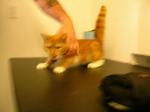
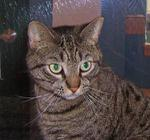
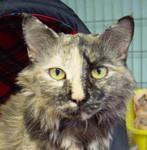
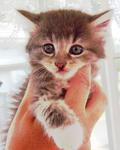
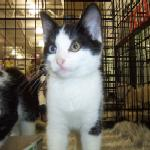
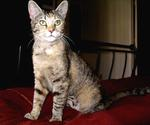
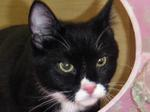
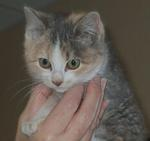
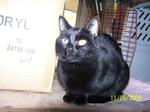
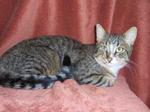
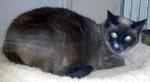
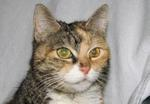
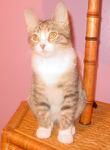
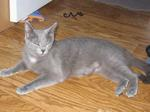
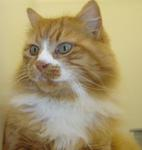
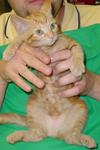
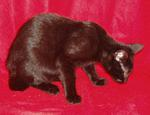
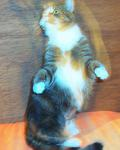
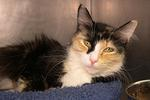
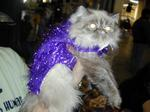
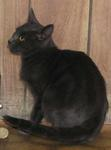
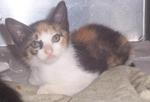
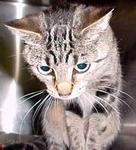
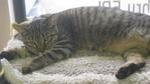
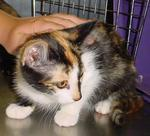
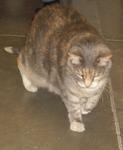
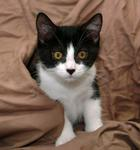
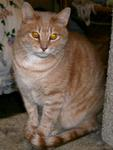
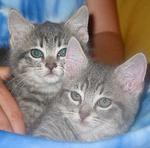
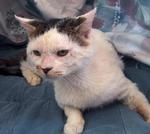


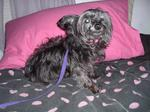
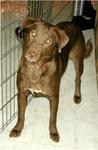
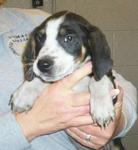
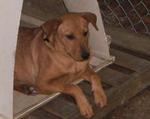
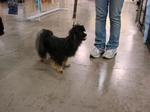
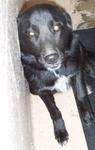
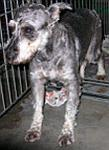
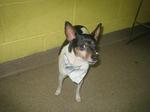
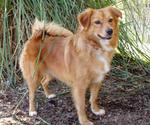
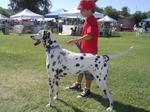
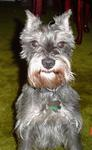
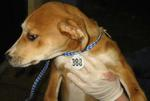
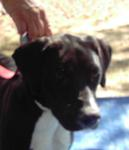
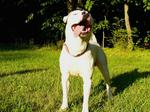
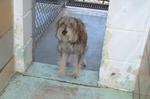
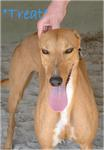
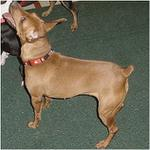
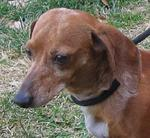
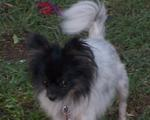
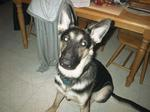
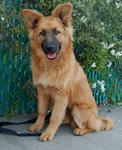
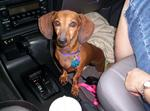
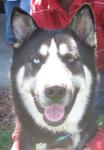
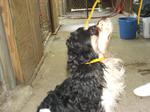
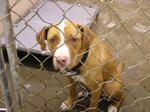
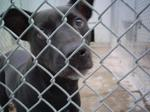
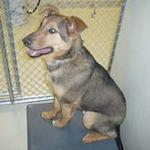
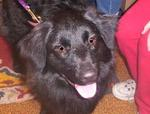
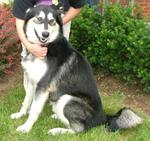
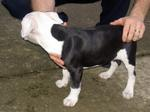

In [38]:
preview_images(reference_data)
preview_images(reference_data[reference_data["label"]=="dog"])

The task is to predict if a picture is a cat or a dog. Let’s explore the use of the image classifier on the Cats vs. Dogs dataset.

In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

In [0]:
# Make a train-test split
train_data, test_data = reference_data.random_split(0.8)

## Create model
https://apple.github.io/turicreate/docs/api/generated/turicreate.image_classifier.create.html

In [13]:
# Create the model
model = tc.image_classifier.create(train_data, target='label')

Performing feature extraction on resized images...
Completed    64/19692
Completed   128/19692
Completed   192/19692
Completed   256/19692
Completed   320/19692
Completed   384/19692
Completed   448/19692
Completed   512/19692
Completed   576/19692
Completed   640/19692
Completed   704/19692
Completed   768/19692
Completed   832/19692
Completed   896/19692
Completed   960/19692
Completed  1024/19692
Completed  1088/19692
Completed  1152/19692
Completed  1216/19692
Completed  1280/19692
Completed  1344/19692
Completed  1408/19692
Completed  1472/19692
Completed  1536/19692
Completed  1600/19692
Completed  1664/19692
Completed  1728/19692
Completed  1792/19692
Completed  1856/19692
Completed  1920/19692
Completed  1984/19692
Completed  2048/19692
Completed  2112/19692
Completed  2176/19692
Completed  2240/19692
Completed  2304/19692
Completed  2368/19692
Completed  2432/19692
Completed  2496/19692
Completed  2560/19692
Completed  2624/19692
Completed  2688/19692
Completed  2752/19692
Com

Logistic regression:

--------------------------------------------------------

Number of examples          : 18742

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 2048

Number of coefficients      : 2049

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 1        | NaN       | 1.720381     | 0.498293          | 0.516842            |

| 1         | 3        | 0.000053  | 4.211653     | 0.981485          | 0.987368            |

| 2         | 6        | 0.500000  | 7.342990     | 0.981966          | 0.989474            |

| 3         | 7        | 0.500000  | 9.115636     | 0.983139          | 0.988421            |

| 4         | 8        | 0.500000  | 10.892599    | 0.984153          | 0.989474            |

| 5         | 9        | 0.500000  | 12.630795    | 0.985434          | 0.991579            |

| 10        | 15       | 1.000000  | 22.001731    | 0.990769          | 0.993684            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [0]:
# Save predictions to an SArray
predictions = model.predict(test_data)

In [15]:
# Evaluate the model and save the results into a dictionary
metrics = model.evaluate(test_data)

Performing feature extraction on resized images...
Completed   64/5077
Completed  128/5077
Completed  192/5077
Completed  256/5077
Completed  320/5077
Completed  384/5077
Completed  448/5077
Completed  512/5077
Completed  576/5077
Completed  640/5077
Completed  704/5077
Completed  768/5077
Completed  832/5077
Completed  896/5077
Completed  960/5077
Completed 1024/5077
Completed 1088/5077
Completed 1152/5077
Completed 1216/5077
Completed 1280/5077
Completed 1344/5077
Completed 1408/5077
Completed 1472/5077
Completed 1536/5077
Completed 1600/5077
Completed 1664/5077
Completed 1728/5077
Completed 1792/5077
Completed 1856/5077
Completed 1920/5077
Completed 1984/5077
Completed 2048/5077
Completed 2112/5077
Completed 2176/5077
Completed 2240/5077
Completed 2304/5077
Completed 2368/5077
Completed 2432/5077
Completed 2496/5077
Completed 2560/5077
Completed 2624/5077
Completed 2688/5077
Completed 2752/5077
Completed 2816/5077
Completed 2880/5077
Completed 2944/5077
Completed 3008/5077
Completed

In [27]:
print(metrics)

0.9913334646444751


## Save and Export Model

In [19]:
# Save the model for later use in Turi Create
model.save('ImageClassifier.model')

# Export for use in Core ML
model.export_coreml('ImageClassifier.mlmodel')

/usr/local/lib/python3.6/dist-packages/coremltools/_deps/__init__.py:118: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  % (tensorflow.__version__, TF_MAX_VERSION))


In [20]:
# download mlmodel locally
from google.colab import files
files.download("ImageClassifier.mlmodel")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 46352, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [22]:
# copy model to Google Drive
from shutil import copy
copy("/content/ImageClassifier.mlmodel", "/content/drive/My Drive/Colab Notebooks/data/models/ImageClassifier.mlmodel")

'/content/drive/Colab Notebooks/data/ImageClassifier.mlmodel'

Test predictions on images from web

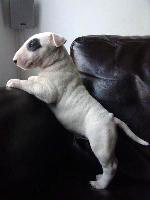

dog


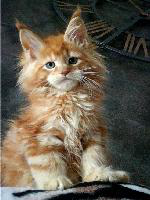

cat


Downloading https://magazin.lionline.sk/wp-content/uploads/2017/11/9-7.jpg to /var/tmp/turicreate-root/14765/71b99b5e-4512-42ff-89ee-eca329a58627.jpg

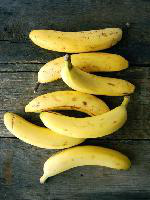

cat


In [41]:
dog_image_url = "https://i.pinimg.com/originals/9a/dd/81/9add8195db39a85b2bfb0791fe5eb871.jpg"
dog_image = tc.Image(dog_image_url)
dog_image_thumb = tc.image_analysis.resize(dog_image, 150, 200)
dog_image_thumb.save("dog_image_thumb.jpg")
dog_image_thumb_pil = Image.open("dog_image_thumb.jpg")
display(dog_image_thumb_pil)
print(model.predict(dog_image))

cat_image_url = "https://i.pinimg.com/originals/1e/ee/89/1eee8994e56beebd25ff7c1f10ded135.jpg"
cat_image = tc.Image(cat_image_url)
cat_image_thumb = tc.image_analysis.resize(cat_image, 150, 200)
cat_image_thumb.save("cat_image_thumb.jpg")
cat_image_thumb_pil = Image.open("cat_image_thumb.jpg")
display(cat_image_thumb_pil)
print(model.predict(cat_image))

other_image_url = "https://magazin.lionline.sk/wp-content/uploads/2017/11/9-7.jpg"
other_image = tc.Image(other_image_url)
other_image_thumb = tc.image_analysis.resize(other_image, 150, 200)
other_image_thumb.save("other_image_thumb.jpg")
other_image_thumb_pil = Image.open("other_image_thumb.jpg")
display(other_image_thumb_pil)
print(model.predict(other_image))

## Changing Models

The image classifier toolkit is based on a technique known as transfer learning. At a high level, model creation is accomplished by simply removing the output layer of the Deep Neural Network for 1000 categories, and taking the signals that would have been propagating to the output layer and feeding them as features to any classifier for our task.

The advanced options let you select from a set of pre-trained models which can result in a model having various size, performance, and accuracy characteristics.

Uses a pretrained model to bootstrap an image classifier:

*   “resnet-50” : Uses a pretrained resnet model. Exported Core ML model will be ~90M.
*   “squeezenet_v1.1” : Uses a pretrained squeezenet model. Exported Core ML model will be ~4.7M.
*   “VisionFeaturePrint_Screen”: Uses an OS internal feature extractor. (Only on available on iOS 12.0+, macOS 10.14+ and tvOS 12.0+). Exported Core ML model will be ~41K.

Using the following option, you can change to use squeezenet which can trade off some accuracy for a smaller model with a lower memory and disk foot-print.

In [28]:
model = tc.image_classifier.create(
               train_data, target='label', model='squeezenet_v1.1')

Download completed: /var/tmp/model_cache/squeezenet_v1.1-symbol.json
Download completed: /var/tmp/model_cache/squeezenet_v1.1-0000.params
Performing feature extraction on resized images...
Completed    64/19692
Completed   128/19692
Completed   192/19692
Completed   256/19692
Completed   320/19692
Completed   384/19692
Completed   448/19692
Completed   512/19692
Completed   576/19692
Completed   640/19692
Completed   704/19692
Completed   768/19692
Completed   832/19692
Completed   896/19692
Completed   960/19692
Completed  1024/19692
Completed  1088/19692
Completed  1152/19692
Completed  1216/19692
Completed  1280/19692
Completed  1344/19692
Completed  1408/19692
Completed  1472/19692
Completed  1536/19692
Completed  1600/19692
Completed  1664/19692
Completed  1728/19692
Completed  1792/19692
Completed  1856/19692
Completed  1920/19692
Completed  1984/19692
Completed  2048/19692
Completed  2112/19692
Completed  2176/19692
Completed  2240/19692
Completed  2304/19692
Completed  2368/196

Logistic regression:

--------------------------------------------------------

Number of examples          : 18691

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1000

Number of coefficients      : 1001

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 1        | NaN       | 0.421222     | 0.499866          | 0.486513            |

| 1         | 6        | 0.000004  | 2.862163     | 0.509604          | 0.500500            |

| 2         | 9        | 5.000000  | 4.579743     | 0.903108          | 0.892108            |

| 3         | 10       | 5.000000  | 5.487260     | 0.867209          | 0.878122            |

| 4         | 12       | 1.000000  | 6.807480     | 0.905730          | 0.906094            |

| 5         | 13       | 1.000000  | 7.728979     | 0.913167          | 0.911089            |

| 10        | 18       | 1.000000  | 12.228380    | 0.918891          | 0.917083            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [29]:
# Save predictions to an SArray
predictions = model.predict(test_data)
# Evaluate the model and save the results into a dictionary
metrics = model.evaluate(test_data)

Performing feature extraction on resized images...
Completed   64/5077
Completed  128/5077
Completed  192/5077
Completed  256/5077
Completed  320/5077
Completed  384/5077
Completed  448/5077
Completed  512/5077
Completed  576/5077
Completed  640/5077
Completed  704/5077
Completed  768/5077
Completed  832/5077
Completed  896/5077
Completed  960/5077
Completed 1024/5077
Completed 1088/5077
Completed 1152/5077
Completed 1216/5077
Completed 1280/5077
Completed 1344/5077
Completed 1408/5077
Completed 1472/5077
Completed 1536/5077
Completed 1600/5077
Completed 1664/5077
Completed 1728/5077
Completed 1792/5077
Completed 1856/5077
Completed 1920/5077
Completed 1984/5077
Completed 2048/5077
Completed 2112/5077
Completed 2176/5077
Completed 2240/5077
Completed 2304/5077
Completed 2368/5077
Completed 2432/5077
Completed 2496/5077
Completed 2560/5077
Completed 2624/5077
Completed 2688/5077
Completed 2752/5077
Completed 2816/5077
Completed 2880/5077
Completed 2944/5077
Completed 3008/5077
Completed

In [31]:
print(metrics)

{'accuracy': 0.909198345479614, 'auc': 0.9752266540367492, 'confusion_matrix': Columns:
	target_label	str
	predicted_label	str
	count	int

Rows: 4

Data:
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|     cat      |       cat       |  2241 |
|     cat      |       dog       |  302  |
|     dog      |       dog       |  2375 |
|     dog      |       cat       |  159  |
+--------------+-----------------+-------+
[4 rows x 3 columns]
, 'f1_score': 0.9115332949529841, 'log_loss': 0.20956560312794, 'precision': 0.8871871497945462, 'recall': 0.9372533543804262, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+--------------------+-----+------+------+
| threshold |        fpr         | tpr |  p   |  n   |
+-----------+--------------------+-----+------+------+
|    0.0    |        1.0         | 1.0 | 2534 | 2543 |
|   1e-05   | 0.9921352732992529 | 1.0

More detailed information: https://apple.github.io/turicreate/docs/userguide/image_classifier/how-it-works.html

### Resnet
Detects the dominant objects present in an image from a set of 1000 categories such as trees, animals, food, vehicles, people, and more. The top-5 error from the original publication is 7.8%. The model is roughly 102.6 MB in size.

*   Source Link: https://github.com/fchollet/deep-learning-models
*   Project Page: https://github.com/KaimingHe/deep-residual-networks>
*   Paper: Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun
*   Keras Implementation: François Chollet
*   Citations: Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition." Paper https://arxiv.org/abs/1512.03385
*   License: MIT License
*   Core ML exported models are usually at least 90MB

### Squeezenet
Detects the dominant objects present in an image from a set of 1000 categories such as trees, animals, food, vehicles, people, and more. With an overall footprint of only 5 MB, SqueezeNet has a similar level of accuracy as AlexNet but with 50 times fewer parameters.

*   Source Link: https://github.com/DeepScale/SqueezeNet
*   Project Page: https://github.com/DeepScale/SqueezeNet
*   Citation: Forrest N. Iandola and Song Han and Matthew W. Moskewicz and Khalid Ashraf and William J. "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size." https://arxiv.org/abs/1602.07360
*   Caffe Implementation: http://deepscale.ai
*   License: BSD License
*   Core ML exported models are usually less than 5MB

### VisionFeaturePrint_Screen
Only available on macOS 10.14 and higher. This model is included in the operating system, so the exported model size is very small.

*   Core ML exported models are about 40KB

## Performance
It’s always important to make sure any machine learning technique is consistent in its usefulness, and that its success is not a fluke. In order to do that, we've tested it on several datasets. For each dataset, the experiment was identical. We trained a model on a dataset of just a small number of images, and then evaluated the accuracy on a completely different dataset of roughly 1800 images per category.

Here is a short summary of results:

### Resnet

Performance on 50 datasets with 5 categories, 25 training examples per category
*   Median accuracy: 0.994667
*   Max accuracy: 1.000000
*   Min accuracy: 0.978667

Performance on 50 datasets with 5 categories, 50 training examples per category
*   Median accuracy: 0.996000
*   Max accuracy: 1.000000
*   Min accuracy: 0.980000

### Squeezenet

Performance on 50 datasets with 5 categories, 25 training examples per category
*   Median accuracy: 0.961333
*   Max accuracy: 0.981333
*   Min accuracy: 0.912000

Performance on 50 datasets with 5 categories, 50 training examples per category
*   Median accuracy: 0.970000
*   Max accuracy: 0.988000
*   Min accuracy: 0.876000

### VisionFeaturePrint_Screen

Performance on 50 datasets with 5 categories, 25 training examples per category
*   Median accuracy: 0.970309
*   Max accuracy: 0.992788
*   Min accuracy: 0.846873

Performance on 50 datasets with 5 categories, 50 training examples per category
*   Median accuracy: 0.976342
*   Max accuracy: 0.988342
*   Min accuracy: 0.944571

To give you some perspective, a user study was made on a dataset with 1000 classes and measured human performance is about 94%.

## Blogs
*   https://hackernoon.com/building-not-hotdog-with-turi-create-and-core-ml-in-an-afternoon-231b14738edf